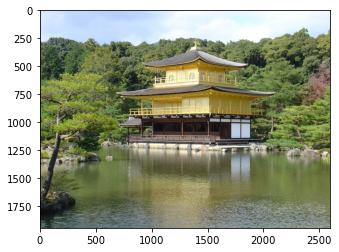

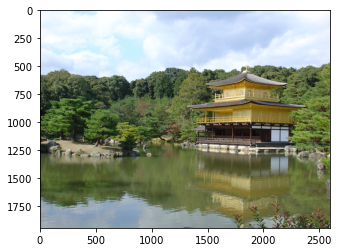

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pymagsac
from time import time

img1 = cv2.cvtColor(cv2.imread('../data/fundamental_matrix/KyotoA.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../data/fundamental_matrix/KyotoB.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [6]:
#We will detect ORB features and match them with cross-check test
det = cv2.SIFT_create(8000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher()

SNN_threshold = 0.85
matches = bf.knnMatch(descs1, descs2, k=2)

# Apply ratio test
snn_ratios = []
tentatives = []
for m, n in matches:
    if m.distance < SNN_threshold * n.distance:
        tentatives.append(m)
        snn_ratios.append(m.distance / n.distance)

# Sort the points according to the SNN ratio.
# This step is required both for PROSAC and P-NAPSAC.
sorted_indices = np.argsort(snn_ratios)
tentatives = list(np.array(tentatives)[sorted_indices])

In [7]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesThickness = 2,
                   flags = 2)
    inliers = [tentatives[k] for k in range(len(matchesMask)) if matchesMask[k] == 1]
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2,kps2,inliers, None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [9]:
def get_probabilities(tentatives):
    probabilities = []

    # Since the correspondences are assumed to be ordered by their SNN ratio a priori,
    # we just assign a probability according to their order.
    for i in range(len(tentatives)):
        probabilities.append(1.0 - i / len(tentatives))
    return probabilities

def verify_pygcransac(kps1, kps2, tentatives, use_magsac_plus_plus, h1, w1, h2, w2, sampler_id):
    correspondences = np.float32([ (kps1[m.queryIdx].pt + kps2[m.trainIdx].pt) for m in tentatives ]).reshape(-1,4)
    probabilities = []
    
    # NG-RANSAC and AR-Sampler require an inlier probability to be provided for each point.
    # Since deep learning-based prediction is not applied here, we calculate the probabilities
    # from the SNN ratio ranks.  
    if sampler_id == 3 or sampler_id == 4:
        probabilities = get_probabilities(tentatives)

    F, mask = pymagsac.findFundamentalMatrix(
        np.ascontiguousarray(correspondences), 
        w1, h1, w2, h2,
        probabilities = probabilities,
        sampler = sampler_id,
        use_magsac_plus_plus = use_magsac_plus_plus,
        max_iters = 5000,
        min_iters = 50,
        sigma_th = 1.5)
    return F, mask

# Test samplers:
# - Uniform sampler from Fischler, Martin A., and Robert C. Bolles. "Random sample consensus: a paradigm for model fitting with applications to image analysis and automated cartography." Communications of the ACM 24.6 (1981): 381-395.
# - PROSAC sampler from Chum, Ondrej, and Jiri Matas. "Matching with PROSAC-progressive sample consensus." 2005 IEEE computer society conference on computer vision and pattern recognition (CVPR'05). Vol. 1. IEEE, 2005.
# - Progressive NAPSAC sampler from Barath, Daniel, et al. "MAGSAC++, a fast, reliable and accurate robust estimator." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2020.
# - NG-RANSAC Sampler from Brachmann, Eric, and Carsten Rother. "Neural-guided RANSAC: Learning where to sample model hypotheses." Proceedings of the IEEE/CVF International Conference on Computer Vision. 2019.
# - Adaptive Reordering Sampler from Tong, Wei, Jiri Matas, and Daniel Barath. "Deep MAGSAC++." arXiv preprint arXiv:2111.14093 (2021).
samplers = [("Uniform", 0), ("PROSAC", 1), ("P-NAPSAC", 2), ("NG-RANSAC Sampler", 3), ("AR-Sampler", 4)]
repetitions = 10

for sampler_name, sampler_id in samplers:    
    print(f"Testing sampler '{sampler_name}' + MAGSAC++.")

    inlier_number = 0
    t = time()
    for rep in range(repetitions):
        F, mask = verify_pygcransac(kps1, kps2, tentatives, True, img1.shape[0], img1.shape[1],
                                        img2.shape[0], img2.shape[1], sampler_id)
        inlier_number += mask.sum()
    print (f"Time = {((time()-t) / repetitions):0.3f} sec")
    print (f"Inlier number = {inlier_number / repetitions}")
    print(50 * "-")


Testing sampler 'Uniform' + MAGSAC++.
Time = 0.166 sec
Inlier number = 474.4
--------------------------------------------------
Testing sampler 'PROSAC' + MAGSAC++.
Time = 0.136 sec
Inlier number = 484.0
--------------------------------------------------
Testing sampler 'P-NAPSAC' + MAGSAC++.
Time = 0.124 sec
Inlier number = 480.8
--------------------------------------------------
Testing sampler 'NG-RANSAC Sampler' + MAGSAC++.
Time = 0.234 sec
Inlier number = 488.6
--------------------------------------------------
Testing sampler 'AR-Sampler' + MAGSAC++.
Time = 0.093 sec
Inlier number = 480.5
--------------------------------------------------
